# Examples of utils provided by ReGraph's neo4j module

In [32]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j import Neo4jGraph
from regraph.neo4j.cypher_utils import *

## Initializing Neo4j graph

0. When installing neo4j you will be asked to choose login/password for you dbs (here its "neo4j"/"admin"), if you choose other -- change in the cell below.
1. To start neo4j server run `sudo service neo4j start`
2. Check status by running `sudo service neo4j status`. Here you can check the _bolt_ port, change the cell below if different from 7687
3. You can query the db by using the neo4j browser, the address can be found also in the result of 'status', e.g. "Remote interface available at http://localhost:7474/".

In [37]:
# initialize the neo4j driver, wrappped into Neo4jGraph object
g = Neo4jGraph(uri="bolt://localhost:7687", user="neo4j", password="admin")

CREATE CONSTRAINT ON (n:node) ASSERT n.id IS UNIQUE


In [38]:
# here we clear the db
res = g._clear()

MATCH (n:node)
OPTIONAL MATCH (n)-[r]-()
DELETE n, r



In [39]:
nodes = [
    ("a", {"name": "Jack", "age": 23, "hobby": {"hiking", "music"}, "weight": 75}), 
    ("b", {"name": "Bob", "age": 24, "hobby": {"sport", "music"}, "height": 178}),
    "c", 
    ("d", {"name": "Paul"}), "e", "f"
]
edges = [
    ("a", "b", {"type": {"friends", "colleagues"}}), 
    ("d", "b", {"type": "enemies"}), 
    ("a", "c"),
    ("d", "a", {"type": "friends"}),
    ("e", "a"), 
    ("f", "d")
]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

OPTIONAL MATCH (same_id_node:node) 
WHERE same_id_node.id = 'a' 
FOREACH(new_count 
	IN CASE WHEN same_id_node IS NOT NULL
	THEN [coalesce(same_id_node.count, 0) + 1]
	ELSE [] END | 
		SET same_id_node.count = new_count) 
WITH same_id_node 
UNWIND
	CASE WHEN same_id_node IS NOT NULL
	THEN ['a' + same_id_node.count]
	ELSE ['a'] END AS new_id 
		CREATE (n:node { id : new_id }) 
SET n.name=['Jack']
SET n.age=[23]
SET n.hobby=['music', 'hiking']
SET n.weight=[75]
RETURN new_id

OPTIONAL MATCH (same_id_node:node) 
WHERE same_id_node.id = 'b' 
FOREACH(new_count 
	IN CASE WHEN same_id_node IS NOT NULL
	THEN [coalesce(same_id_node.count, 0) + 1]
	ELSE [] END | 
		SET same_id_node.count = new_count) 
WITH same_id_node 
UNWIND
	CASE WHEN same_id_node IS NOT NULL
	THEN ['b' + same_id_node.count]
	ELSE ['b'] END AS new_id 
		CREATE (n:node { id : new_id }) 
SET n.name=['Bob']
SET n.age=[24]
SET n.hobby=['music', 'sport']
SET n.height=[178]
RETURN new_id

OPTIONAL MATCH (same_id_node:node) 
WHERE s

In [40]:
g.get_node("a")

MATCH (n:node { id: 'a' }) 
RETURN properties(n) as attributes



{'name': {'Jack'}, 'weight': {75}, 'age': {23}, 'hobby': {'music', 'hiking'}}

## Primitive operations on Neo4j graph

### Basic operations

In [41]:
g.add_node("x", {"name": "Roberto"})

OPTIONAL MATCH (same_id_node:node) 
WHERE same_id_node.id = 'x' 
FOREACH(new_count 
	IN CASE WHEN same_id_node IS NOT NULL
	THEN [coalesce(same_id_node.count, 0) + 1]
	ELSE [] END | 
		SET same_id_node.count = new_count) 
WITH same_id_node 
UNWIND
	CASE WHEN same_id_node IS NOT NULL
	THEN ['x' + same_id_node.count]
	ELSE ['x'] END AS new_id 
		CREATE (n:node { id : new_id }) 
SET n.name=['Roberto']
RETURN new_id



'x'

In [42]:
g.add_edge("x", "c", {"type": {"friends", "colleagues"}, "since": 1993})

MATCH (s:node { id : 'x'}) , (t:node { id : 'c'})  CREATE (s)-[new_edge:edge { type: ['friends', 'colleagues'], since: [1993] }]->(t)



In [8]:
g.nodes()

MATCH (n:node) RETURN n.id



['f', 'x', 'a', 'b', 'c', 'd', 'e']

In [9]:
g.edges()

MATCH (n:node)-[r:edge]->(m:node)
RETURN n.id, m.id



[('f', 'd'),
 ('x', 'c'),
 ('a', 'c'),
 ('a', 'b'),
 ('d', 'a'),
 ('d', 'b'),
 ('e', 'a')]

In [10]:
g.get_edge('a', 'b')

MATCH ({ id: 'a' })-[rel:edge]->({ id: 'b' }) 
RETURN properties(rel) as attributes



{'type': {'friends', 'colleagues'}}

### Cloning

By default if we clone a node without specifying the new id for it, the id is automatically derived from the original one (however it takes some additional time to generate it, and some naming collisions may happen in the future when using clone operation inside of complex queries)

In [43]:
clone1_res = g.clone_node('a')
print("Created clone by the name: ", clone1_res)
print("Properties of the resulting node: ")
print(g.get_node(clone1_res))
print("Properties of incident edges are also cloned, e.g: ")
print(g.get_edge(clone1_res, 'b'))

MATCH (x:node { id : 'a' })
// search for a node with the same id as the clone id
OPTIONAL MATCH (same_id_node:node { id : 'a'}) 
WITH same_id_node,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, x
// generate new id if the same id node was found
// and filter edges which will be removed 
WITH same_id_node, same_id_node_new_count, 'a' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as uid, x
// create a node corresponding to the clone
CREATE (new_node:node) 
WITH same_id_node, same_id_node_new_count, new_node, uid, x.id as original_old, x
// set the id property of the original node to NULL
SET x.id = NULL
// copy all the properties of the original node to the clone
SET new_node = x
// set id property of the clone to the generated id
SET new_node.id = uid, new_node.count = NULL, same_id_node.count = same_id_node_new_count + 1
// set back the id property of the original node
SE

We can specify the parameter `ignore_naming=True` to avoid automatic id derivation. In this case cloning uses Neo4j native ids (this mode is more suitable for using clone operation inside of complex queries as the Neo4j id have the guaranteed uniqueness)

In [12]:
print("Here we ignore pretty naming of new clones\n")
clone2_res = g.clone_node('a', ignore_naming=True)
print("Created clone by the name: ", clone2_res)
print("Properties of the resulting node: ")
print(g.get_node(clone2_res))
print("Properties of incident edges are also cloned, e.g: ")
print(g.get_edge(clone2_res, 'b'))

Here we ignore pretty naming of new clones

MATCH (x:node { id : 'a' })
// create a node corresponding to the clone
CREATE (new_node:node) 
WITH new_node, toString(id(new_node)) as uid, x.id as original_old, x 
// set the id property of the original node to NULL
SET x.id = NULL
// copy all the properties of the original node to the clone
SET new_node = x
// set id property of the clone to neo4j-generated id
SET new_node.id = toString(id(new_node)), new_node.count = NULL
// set back the id property of the original node
SET x.id = original_old
WITH new_node, toString(id(new_node)) as uid, x 
WITH [] as sucIgnore, [] as predIgnore, x, new_node, uid 
// match successors and out-edges of a node to be cloned
OPTIONAL MATCH (x)-[out_edge:edge]->(suc) 
WHERE NOT suc.id IS NULL AND NOT suc.id IN sucIgnore
WITH collect({neighbor: suc, edge: out_edge}) as suc_maps, uid, new_node, sucIgnore, predIgnore, x 
// match predecessors and in-edges of a node to be cloned
OPTIONAL MATCH (pred)-[in_edge:edg

The third option is to specify the id of the new node manually

In [13]:
clone3_res = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", clone3_res)
print("Properties of the resulting node: ")
print(g.get_node(clone3_res))
print("Properties of incident edges are also cloned, e.g: ")
print(g.get_edge(clone3_res, 'b'))

MATCH (x:node { id : 'a' })
// search for a node with the same id as the clone id
OPTIONAL MATCH (same_id_node:node { id : 'a_clone'}) 
WITH same_id_node,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, x
// generate new id if the same id node was found
// and filter edges which will be removed 
WITH same_id_node, same_id_node_new_count, 'a_clone' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as uid, x
// create a node corresponding to the clone
CREATE (new_node:node) 
WITH same_id_node, same_id_node_new_count, new_node, uid, x.id as original_old, x
// set the id property of the original node to NULL
SET x.id = NULL
// copy all the properties of the original node to the clone
SET new_node = x
// set id property of the clone to the generated id
SET new_node.id = uid, new_node.count = NULL, same_id_node.count = same_id_node_new_count + 1
// set back the id property of the orig

In [44]:
merge1_res = g.merge_nodes1(["a", "b"])
print("Properties of the resulting node: {}".format(merge1_res))
print(g.get_node(merge1_res))

MATCH (a:node { id : 'a'}) , (b:node { id : 'b'})  
// accumulate all the attrs of the nodes to be merged
WITH [] as new_props, a, b
WITH new_props + REDUCE(pairs = [], k in keys(a) | 
	pairs + REDUCE(inner_pairs = [], v in a[k] | 
		inner_pairs + {key: k, value: v})) as new_props, a, b
WITH new_props + REDUCE(pairs = [], k in keys(b) | 
	pairs + REDUCE(inner_pairs = [], v in b[k] | 
		inner_pairs + {key: k, value: v})) as new_props, a, b
WITH apoc.map.groupByMulti(new_props, 'key') as new_props, a, b
WITH apoc.map.fromValues(REDUCE(pairs=[], k in keys(new_props) | 
	pairs + [k, REDUCE(values=[], v in new_props[k] | 
		values + CASE WHEN v.value IN values THEN [] ELSE v.value END)])) as new_props, a, b
SET a = new_props
WITH a as merged_node, b
// search for a node with the same id as the clone id
OPTIONAL MATCH (same_id_node:node { id : 'a_b'}) 
WITH same_id_node,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, merge

In [15]:
merge2_res = g.merge_nodes(["a_b", "d"])
print("Properties of the resulting node: {}".format(merge2_res))
print(g.get_node(merge2_res))

MATCH (n1:node { id : 'a_b'}) , (n2:node { id : 'd'})  
// use the APOC procedure 'apoc.refactor.mergeNodes' to merge nodes
CALL apoc.refactor.mergeNodes([n1, n2], {properties: 'combine'})
YIELD node as merged_node
// search for a node with the same id as the clone id
OPTIONAL MATCH (same_id_node:node { id : 'a_b_d'}) 
WITH same_id_node,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, merged_node
// generate new id if the same id node was found
// and filter edges which will be removed 
WITH same_id_node, same_id_node_new_count, 'a_b_d' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as new_id, merged_node
// set appropriate node id
SET merged_node.id = new_id
SET merged_node.count = NULL
WITH new_id, merged_node
// find and merge multiple relations resulting from the node merge
OPTIONAL MATCH (merged_node)-[out_rel:edge]->(suc)
WITH collect({neighbor: suc, edge: out_rel}) as 

## Rewriting Neo4j graph

### 1. Create an SqPO rewriting rule

In [45]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z"])
pattern.add_edges_from([("y", "x"), ("y", "z"), ("z", "z")])

In [46]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

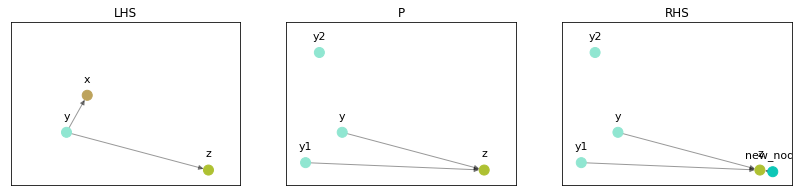

CLONE y AS y2.
CLONE y AS y1.
DELETE_NODE x.
DELETE_EDGE y2 z.
ADD_NODE new_node {}.
ADD_EDGE new_node z {}.



In [47]:
plot_rule(rule)
print(rule.to_commands())

In [48]:
instances = g.find_matching(pattern)
print("\n\nInstances: ", instances)

MATCH (`x`:node), (`y`:node), (`z`:node), (`y`)-[:edge]->(`x`), (`y`)-[:edge]->(`z`), (`z`)-[:edge]->(`z`)
WHERE id(`x`) <> id(`y`) AND id(`y`) <> id(`z`)
RETURN `x`, `y`, `z`


Instances:  [{'x': 'c', 'y': 'a1', 'z': 'a_b'}, {'x': 'a1', 'y': 'e', 'z': 'a_b'}, {'x': 'a1', 'y': 'd', 'z': 'a_b'}]


In [49]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

MATCH (x:node { id : 'a1' })
// search for a node with the same id as the clone id
OPTIONAL MATCH (same_id_node:node { id : 'a1'}) 
WITH same_id_node,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, x
// generate new id if the same id node was found
// and filter edges which will be removed 
WITH same_id_node, same_id_node_new_count, 'a1' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as uid, x
// create a node corresponding to the clone
CREATE (new_node:node) 
WITH same_id_node, same_id_node_new_count, new_node, uid, x.id as original_old, x
// set the id property of the original node to NULL
SET x.id = NULL
// copy all the properties of the original node to the clone
SET new_node = x
// set id property of the clone to the generated id
SET new_node.id = uid, new_node.count = NULL, same_id_node.count = same_id_node_new_count + 1
// set back the id property of the original node

In [21]:
rhs_g

{'y': 'a11', 'z': 'a_b_d', 'y1': 'a13', 'y2': 'a1', 'new_node': 'new_node'}